# Compare Price and Speed

This notebook runs 7 days (2915-2922) on a number of CPU and GPU instance types.  This information will then be used to select the best instance type for the [hyper-parameter tunning](tuning.ipynb).

#### Import necessary modules

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import boto3
import math
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
import seaborn as sns; sns.set()
from time import sleep

#### Get the necessary account information

In [2]:
role = get_execution_role()
account = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name
image_names = {}
for t in ['cpu', 'gpu']:
    image_names[t] = '{}.dkr.ecr.{}.amazonaws.com/portfolio-optimization-{}:latest'.format(account, region, t)
    print(image_names[t])

031118886020.dkr.ecr.us-east-1.amazonaws.com/portfolio-optimization-cpu:latest
031118886020.dkr.ecr.us-east-1.amazonaws.com/portfolio-optimization-gpu:latest


#### Set for local parameters
Prices are in $/hour and are from [here](https://aws.amazon.com/sagemaker/pricing/).

These were selected based on the sensitivity [notebook](https://github.com/daniel-fudge/sagemaker-tennis/blob/master/sensitivity.ipynb) in the related [Tennis](https://github.com/daniel-fudge/sagemaker-tennis) repo.

In [3]:
start_day = 2915
n_instances = 1

c = {'ml.m5.large': 0.134,
     'ml.c5.xlarge': 0.238, 
     'ml.m4.2xlarge': 0.56,
     'ml.c5n.xlarge': 0.302}
c = pd.DataFrame(index=c.keys(), columns=['price'], data=c.values())
c['type'] = 'cpu'

g = {'ml.g4dn.xlarge': 0.736, 
     'ml.g4dn.2xlarge': 1.053}
g = pd.DataFrame(index=g.keys(), columns=['price'], data=g.values())
g['type'] = 'gpu'

results = pd.concat([c, g])
results['job_name'] = ''
results['time'] = np.nan
del c, g
results

,price,type,job_name,time
ml.m5.large,0.134,cpu,,NaN
ml.c5.xlarge,0.238,cpu,,NaN
ml.m4.2xlarge,0.560,cpu,,NaN
ml.c5n.xlarge,0.302,cpu,,NaN
ml.g4dn.xlarge,0.736,gpu,,NaN
ml.g4dn.2xlarge,1.053,gpu,,NaN


### Please verify that the prices above haven't changed!!!
You may also want to add newly added instances.

### Run Sensitivity

#### Submit all the jobs

In [4]:
for i in results.index.tolist():
    estimator = Estimator(role=role,
                      train_instance_count=n_instances,
                      train_instance_type=i,
                      image_name=image_names[results.loc[i, 'type']],
                      hyperparameters={'start_day': start_day})
    estimator.fit(wait=False)
    results.loc[i, 'job_name'] = estimator._current_job_name

#### Wait for the jobs to complete and compile billable times
Note times are in seconds but prices in $/hour.

In [5]:
client = boto3.client('sagemaker')
for i in results.index.tolist():
    while True:
        info = client.describe_training_job(TrainingJobName=results.loc[i, 'job_name'])
        if info['TrainingJobStatus'] == 'Completed':
            results.loc[i, 'time'] = info['BillableTimeInSeconds']
            print('{} complete.'.format(i))
            break
        elif info['TrainingJobStatus'] == 'Failed':
            print('ERROR:  {}, {} failed!!!'.format(i, results.loc[i, 'job_name']))
            break
        else:
            sleep(60)    

ml.m5.large complete.
ml.c5.xlarge complete.
ml.m4.2xlarge complete.
ml.c5n.xlarge complete.
ml.g4dn.xlarge complete.
ml.g4dn.2xlarge complete.


#### Compile the job info
Note the cost is in cents, time in seconds and price in \\$ per hour.  
3600 converts seconds to hours and 100 converts \\$ to cents.


In [6]:
results['cost'] = results['price'] * results['time'] / 3600 * 100
results['eff'] = results['cost'] * results['time']
results.to_csv('results.csv')
results


,price,type,job_name,time,cost,eff
ml.m5.large,0.134,cpu,portfolio-optimization-cpu-2020-07-11-23-23-17...,287.0,1.068278,306.595722
ml.c5.xlarge,0.238,cpu,portfolio-optimization-cpu-2020-07-11-23-23-18...,260.0,1.718889,446.911111
ml.m4.2xlarge,0.560,cpu,portfolio-optimization-cpu-2020-07-11-23-23-18...,388.0,6.035556,2341.795556
ml.c5n.xlarge,0.302,cpu,portfolio-optimization-cpu-2020-07-11-23-23-18...,286.0,2.399222,686.177556
ml.g4dn.xlarge,0.736,gpu,portfolio-optimization-gpu-2020-07-11-23-23-29...,163.0,3.332444,543.188444
ml.g4dn.2xlarge,1.053,gpu,portfolio-optimization-gpu-2020-07-11-23-23-29...,287.0,8.394750,2409.293250


#### Make a pretty plot 

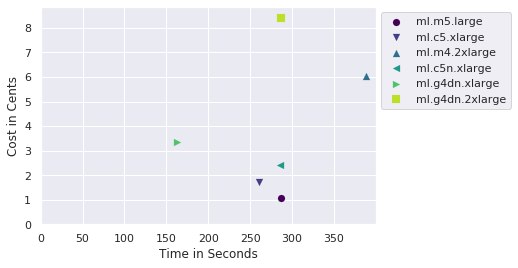

In [10]:
import matplotlib.cm as cm
import matplotlib.colors as colors

colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, results.shape[0])]

markers = ['o', 'v', '^', '<', '>', 's', 
           '*', 'X', 'P', 'D'] * math.ceil(results.shape[0]/10)

fig, ax = plt.subplots()
for i, name in enumerate(results.index.tolist()):
    ax.scatter(results.loc[name, 'time'], results.loc[name, 'cost'], label=name, s=50, 
               linewidth=0.1, c=colorlist[i], marker=markers[i])
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# ax = results.plot.scatter(x='time', y='cost', c='blue')
_ = ax.set(xlabel="Time in Seconds", ylabel="Cost in Cents")
plt.show()

# Conclusion

In [8]:
for n, t in zip([results.price.idxmin(), results.time.idxmin(), results.eff.idxmin()],
                ['cheapest', 'fastest', 'most efficient']):
    print("{} is the {} instance type; {:.1f} min and ${:.3f}.".format(n, t, 
                                                                    results.loc[n, 'time']/60,
                                                                    results.loc[n, 'cost']/100))


ml.m5.large is the cheapest instance type; 4.8 min and $0.011.
ml.g4dn.xlarge is the fastest instance type; 2.7 min and $0.033.
ml.m5.large is the most efficient instance type; 4.8 min and $0.011.


# Reference
- [Tennis Sensitivity](https://github.com/daniel-fudge/sagemaker-tennis/blob/master/sensitivity.ipynb)
- [Tennis Repo](https://github.com/daniel-fudge/sagemaker-tennis)
#### SageMaker
- [SageMaker Instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/)
- [SageMaker Instance prices](https://aws.amazon.com/sagemaker/pricing/)
- [SageMaker Estimator SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)